### Portfolio Optimization

#### Import required libraries

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

#### Section 1: Define Tickers and Time Range

In [3]:
# Define the list of tickers
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [5]:
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)
print(start_date)

2019-04-16 16:01:10.532581


In [6]:
print(end_date)

2024-04-14 16:01:10.532581


#### Section 2: Download Adjusted Close Prices

In [8]:
# Create an empty dataframe to store the adjusted close prices
adj_close_df = pd.DataFrame()
# Download the close prices for each ticker
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
### Display the DataFrame
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2019-04-16  267.747589  70.646645  120.510002  180.550385  137.192749
2019-04-17  267.092499  70.646645  120.279999  181.179626  136.685013
2019-04-18  267.618408  70.743233  120.370003  181.411972  136.888092
2019-04-22  267.849091  70.672989  120.370003  181.925034  136.925064
2019-04-23  270.257507  70.795906  120.120003  184.238815  138.300629
...                ...        ...         ...         ...         ...
2024-04-08  518.719971  71.620003  216.479996  440.600006  257.480011
2024-04-09  519.320007  71.879997  217.669998  442.230011  257.850006
2024-04-10  514.119995  71.040001  215.610001  438.369995  254.970001
2024-04-11  518.000000  71.040001  219.800003  445.369995  256.700012
2024-04-12  510.850006  71.199997  216.889999  438.269989  253.000000

[1257 rows x 5 columns]


#### Section 3: Calculate Lognormal Returns

In [11]:
## Calculate the lognormal returns for each ticker
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [12]:
# Drop any missing values
log_returns = log_returns.dropna()

#### Section 4: Calculate Covariance Matrix

In [13]:
# Calculate covariance matrix using annualized log returns
cov_matrix = log_returns.cov()*252

In [14]:
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.044271  0.002822  0.003787  0.049904  0.045331
BND  0.002822  0.004735  0.003886  0.003424  0.003009
GLD  0.003787  0.003886  0.022644  0.005042  0.003980
QQQ  0.049904  0.003424  0.005042  0.064850  0.051050
VTI  0.045331  0.003009  0.003980  0.051050  0.046796


#### Section 5: Define Portfolio Performance Metrics

**Calculate the portfolio standard deviation**

This line of code calculates the portfolio variance, which is a measure of the risk associated with a portfolio of assets. It represents the combined volatility of the assets in the portfolio, taking into account their individual volatilities and correlations with each other. 

In [15]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

**Calculate the expected return**
* Key assumption: Expected returns are based on historical returns

In [17]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

#### Calculate Sharpe Ratio

In [18]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return(expected_return(weights, log_returns)-risk_free_rate) / standard_deviation(weights, cov_matrix)

#### Section 6: Portfolio Optimization

In [20]:
# Set the risk free rate
from fredapi import Fred

# Replace "your_api_key" with your actual FRED API Key
fred = Fred(api_key='50afc3e3f77c91b124b8da9ce9259216')
ten_year_treasury_rate = fred.get_series_latest_release('GS10')/100

# Set the risk free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.0421


#### Define the function to minimize (negative Sharpe Ratio)

In the case of the scipy.optimize.minimize() function, there is no direct method to find the maximum value of a function.

In [21]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#### Set the constraints and bounds

Constraints are conditions that must be met by the solution during the optimization process. In this case, the constraint is that the sum of all portfolio weights must be equal to 1. The constraints variable is a dictionary with two keys, 'type' and 'fun'. 'type' is set to 'eq', which means 'equally constraint', and 'fun' is assigned the function check_sum, which checks if the sum of the portfolio weights equals 1. 

Bounds are the limits placed on the variables during the optimization process. In this case, the variables are the portfolio weights , and each weight should be between 0 and 1. 

In [22]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0,0.5) for _ in range(len(tickers))]

#### Set the initial weights

In [23]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


#### Optimize the weights to maximize the Sharpe Ratio

'SLSQP' stands for Sequential Least Squares Quadratic Programming, which is a numerical optimization technique suitable for solving nonlinear optimization problems with constraints.

In [24]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

#### Get the optimal weights

In [25]:
optimal_weights = optimized_results.x

#### Section 7: Analyze the Optimal Portfolio

**Display analytics of the optimal portfolio**

In [26]:
print('Optimal weights:')
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal weights:
SPY: 0.0000
BND: 0.5000
GLD: 0.0000
QQQ: 0.0000
VTI: 0.5000

Expected Annual Return: 0.0622
Expected Volatility: 0.1199
Sharpe Ratio: 0.1674


#### Display the final portfolio in a plot

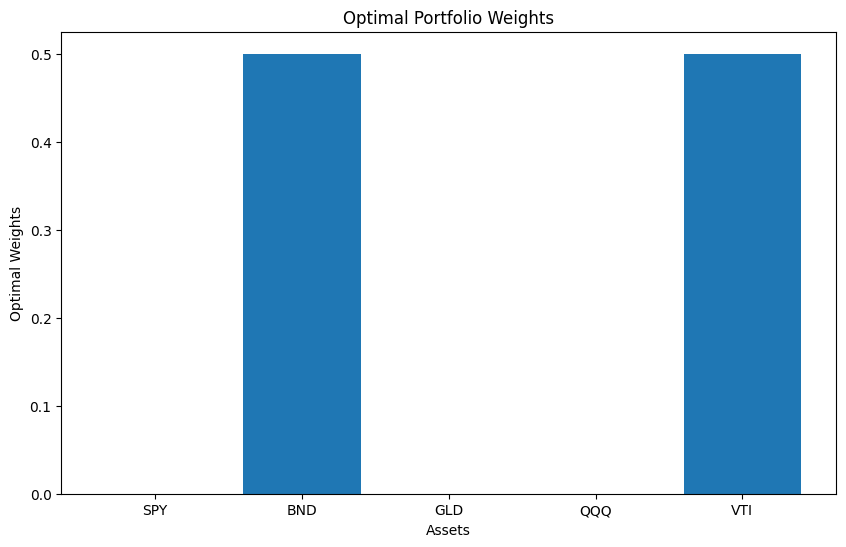

In [27]:
import matplotlib.pyplot as plt

# Import the required library
import matplotlib.pyplot as plt

# Create a bar chart of the optimal weights
plt.figure(figsize=(10,6))
plt.bar(tickers, optimal_weights)

# Add labels and a ticker
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

# Display the chart
plt.show()